In [1]:
from datascience import *
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from toolz import memoize

# Classifiers (Review)
In the previous lecture, we went over "the nearest neighbors" classifier and implemented it in code. We will recap the high-level ideas of classification and the nearest neighbor classifier, then we'll discuss more on how to choose a good classifier.

## Nearest Neighbor Classifier
Recall how the `Nearest Neighbor Classifier` works:
<img src = 'email_1.jpg' width = 400/>

We take the attributes of an example and match it with the data that we have at the `training set`. If the attributes are close enough to some of the data that are in the `training set`, then we can predict the label of the example.

## The Classifier
To classify a point (or an example):
1. Find its `k` nearest neighbors
    * `k` is the number of neighbors we are going to look
    * `k` is usually an odd number, to prevent ties

2. Take a majority vote of the `k` nearest neighbors to see which of the 2 classes appear more often

3. Assign the point the class that wins the majority vote

## Demo - Nearest Neighbor Classifier (Review)
Below we have the `patients` dataset from previous lecture,

In [2]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients.show(3)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0


Recall from previous lecture that we constructed a scatter plot where we had to jitter the data points so that they don't gather in one spot,

In [3]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

In [4]:
jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

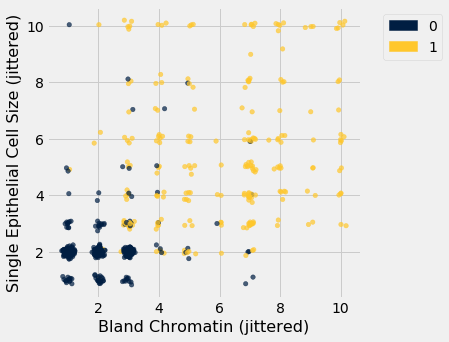

In [5]:
jittered.scatter(0, 1, colors='Class')

We also defined `distance` of 2 data points according to Euclidean distance,

In [6]:
def distance(pt1, pt2):
    """ The distance between 2 points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2) ** 2))

def row_distance(row1, row2):
    """ The distance between 2 rows of a table"""
    return distance(np.array(row1), np.array(row2))

And we defined functions for classfifying a data point based on `k` nearest neighbors,

In [7]:
def distances(training, example):
    """ Compute the distance between an example and each row in training set"""
    dists = [] # This list contains all the calculated distances
    
    # Below we take the training set and drop the labels. At this point we don't care about
    # the labels. We only care about the attributes.
    attributes = training.drop('Class')
    # For every row in 'attributes', compute the distance between the row and the example
    # then append the computed distance to the 'dists' list
    for row in attributes.rows:
        dists.append(row_distance(row, example))
    
    # Return the training table with an additional column : the computed distances
    return training.with_column('Distance', dists)

def closest(training, example, k):
    """ Return a table of the k closest neighbors to example."""
    # Sort by 'Distance', then take 'k' neighbors
    return distances(training, example).sort('Distance').take(np.arange(k))

def majority_class(top_k):
    """ Return the class with the highest count. """
    # Group the table by class, then sort in descending order (the most appear at the top),
    # then pick the top item
    return top_k.group('Class').sort('count', descending = True).column(0).item(0)

def classify(training, example, k):
    """ Return the majority class among k nearest neighbors"""
    return majority_class(closest(training, example, k))

Now if we set our example as the 12th patient,

In [8]:
example = patients.drop('Class').row(12)
example

Row(Clump Thickness=5, Uniformity of Cell Size=3, Uniformity of Cell Shape=3, Marginal Adhesion=3, Single Epithelial Cell Size=2, Bare Nuclei=3, Bland Chromatin=4, Normal Nucleoli=4, Mitoses=1)

and try to classify the example based on `5` nearest neighbor,

In [9]:
classify(patients.exclude(12), example, 5)

0

Then we'll obtain `0`! But if we look at the attributes of 12th patient,

In [10]:
patients.row(12)

Row(Clump Thickness=5, Uniformity of Cell Size=3, Uniformity of Cell Shape=3, Marginal Adhesion=3, Single Epithelial Cell Size=2, Bare Nuclei=3, Bland Chromatin=4, Normal Nucleoli=4, Mitoses=1, Class=1)

The correct class is actually `1`! The classifier was wrong!

If we try again with a different patient (this time, let's use patient #20),

In [11]:
example = patients.drop('Class').row(20)
example

Row(Clump Thickness=7, Uniformity of Cell Size=3, Uniformity of Cell Shape=2, Marginal Adhesion=10, Single Epithelial Cell Size=5, Bare Nuclei=10, Bland Chromatin=5, Normal Nucleoli=4, Mitoses=4)

In [12]:
classify(patients.exclude(20), example, 5)

1

In [13]:
patients.row(20)

Row(Clump Thickness=7, Uniformity of Cell Size=3, Uniformity of Cell Shape=2, Marginal Adhesion=10, Single Epithelial Cell Size=5, Bare Nuclei=10, Bland Chromatin=5, Normal Nucleoli=4, Mitoses=4, Class=1)

Then obtain the correct result!

Overall, how do the classifier do on the entire dataset?

# Evaluation

## Accuracy of a Classifier
The accuracy of a classifier on a labeled data set is the proportion of examples that are labeled correctly. To assess the accuracy, we need to compare classifier predictions to actual labels.

If the labeled data set is sampled at random from a population, then we can infer accuracy on that population.
    
<img src = 'sets.jpg' width = 400/>

If the sample was drawn randomly, then the `test set` is also a random sample from the population. By assessing the accuracy of the `test set`, we can infer the accuracy for the entire population. 

If we try to evaluate the classifier on the `training set`, we'll get bad results.

Recall from the previous lecture that we shuffled `patients` table and split it to 2 sets: `trainset` and `testset`,

In [14]:
shuffled = patients.sample(with_replacement = False)
trainset = shuffled.take(range(342))
testset = shuffled.take(range(342, 683))

Why do we need to shuffle the dataset? To anticipate in the case that the dataset has an ordering (e.g. all Class `0` are at the upper part of the table, all Class `1` are at the bottom part of the table)

We also defined a function `evaluate_accuracy` that computes the accuracy of the classifier,

In [15]:
def evaluate_accuracy(training, test, k):
    # take the test set and drop the `Class` attribute, assign it to 'test_attributes'
    test_attributes = test.drop('Class')
    numcorrect = 0 # Keeps track of how many 'corrects' we get
    for i in range(test.num_rows): #go thorugh each patients in test set
        # Run the classifier on each i (each patient)
        c = classify(training, test_attributes.row(i), k)
        # Check if the classifier's correct
        if c == test.column('Class').item(i):
            numcorrect = numcorrect + 1 
    return numcorrect / test.num_rows

And below we have a demo,

In [16]:
def plot_test_point(n):
    trainset.scatter(0, 1, colors='Class')
    point = testset.row(n)
    print('Original class:', point.item('Class'))
    plt.scatter(point.item(0) + 0.2, point.item(1) + 0.2, c='red', s=100)
    plt.show()
    
_ = interact(plot_test_point, n=101)

interactive(children=(IntSlider(value=101, description='n', max=303, min=-101), Output()), _dom_classes=('widg…

Above, we have our training set points. The red dot is a point (row `n`) from the `test set`. Here we take a look at the red point and see what the classifier would have guessed. The classifier guesses the class by taking the `red` dot close one of the spots. If the `Original class` matches the color of the closest spot, then the guess is correct. 

In reality, we don't make classification just solely based on 2 variables like what we did with the scatter plot above. The function `evaluate_accuracy` takes into account all 9 variables. We'll use `evaluate_accuracy` to look at all the points in the `test set` and analyze the accuracy of the classifier

Now we can ask Python to look at all the points in the `test set` and analyze the accuracy of the classifier. Below we evaluate the accuracy with `1` nearest neighbors

In [17]:
evaluate_accuracy(trainset, testset, 1)

0.9648093841642229

We obtain a relatively high accuracy! How about with `5` nearest neighbors?

In [18]:
evaluate_accuracy(trainset, testset, 5)

0.9589442815249267

In [19]:
evaluate_accuracy(trainset, testset, 9)

0.9589442815249267

Above, as we increase `k`, the accuracy seems increasing! However, past certain point, the accuracy would decrease!

In [20]:
evaluate_accuracy(trainset, testset, 153)

0.9120234604105572

Why? This is because we take into account `153` nearest neighbors! This means when we look at the closest data points, most likely we'll take into account the far ones too!

## Discussion Question
Below we have the plot of the `training set`,

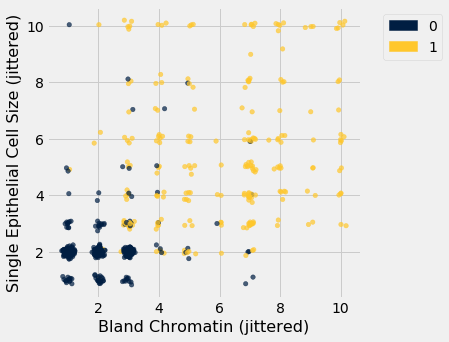

In [21]:
jittered.scatter(0, 1, colors='Class')

What is the accuracy of the `1` Nearest Neighbor classifier on the `training set`?

### Ans: 100%!

If we look at the accuracy of the `training set` with itself, then the nearest neighbor of a point is the point itself. 

Problem is, if we use the `training set` to find the best `k`, and we don't split the data to `training set` and `test set`, then the best `k` would be `1` since it gives perfect accuracy. 

Unfortunately, we shouldn't use the `training set` to evaluate the classifier. Once we trained the classifier with the `training set`, we need a dataset that has not been touched by the `training set`.

### How big the `training set` and the `test set` should be?
We need to have a balance between the `training set` and the `test set`. Typically, more data points should be in the `training set` so that the classifier can be more accurate. However, as we lose points in the `test set`, it gets more difficult to evaluate the classifier. Depending on the dataset, if we have enough data, a common ratio between `training set` and `train set` would be 80:20 or 90:10. 

### Which value of `k` is the best?
Usually we don't know which `k` is the best until we compute the accuracy. For the case of using the `training set` to evaluate the accuracy,

In [22]:
evaluate_accuracy(trainset, trainset, 1)

1.0

We obtain 100% accuracy, but doesn't mean `1` is the best `k`. This case is problematic because we used `training set` to evaluate the accuracy, which we shouldn't do.

In the normal case, we can see that `k` = `9` is better than `k` = `1`,

In [23]:
evaluate_accuracy(trainset, testset, 1)

0.9648093841642229

In [24]:
evaluate_accuracy(trainset, testset, 9)

0.9589442815249267

Here, we use the `test set` to pick the `k` value for the classifier. This means we classify the `test set` over and over again to pick `k`. This means the classifier has touched the data in the `test set`. We can't use the accuracy obtained from the `test set` to state the accuracy on the population. We would need a 3rd set of data that are untouched by the classifier.

Usually, when we split data to `training set` and `test set`, we split the data to 3: `training`, `test`, and `validation`. 

## What's the Difference Between `test set` and `validation set`?
We use a `test set` to choose `k`, then we use the `validation set` to get the final accuracy of the classifier. 

# Decision Boundaries
Recall the CKD dataset,

In [25]:
ckd = Table.read_table('ckd.csv').relabel('Blood Glucose Random', 'Glucose')
ckd.show(3)

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Glucose,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1


In [26]:
kidney = ckd.select('Hemoglobin', 'Glucose', 'Class')
kidney

Hemoglobin,Glucose,Class
11.2,117,1
9.5,70,1
10.8,380,1
5.6,157,1
7.7,173,1
9.8,95,1
12.5,264,1
10,70,1
10.5,253,1
9.8,163,1


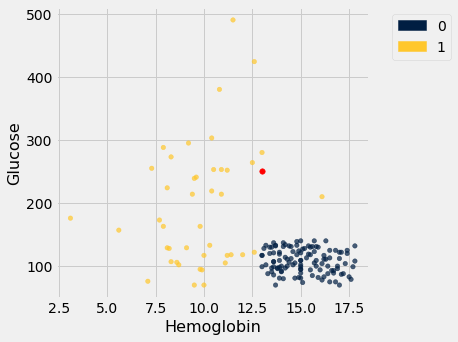

In [27]:
kidney.scatter(0, 1, colors = 2)
plt.scatter(13, 250, color = 'red', s = 30)

Above is a plot of the 2 attributes. We want to categorize the red data point by looking at its nearest neighbor,

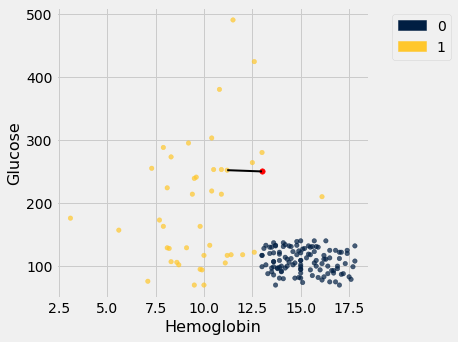

In [28]:
def show_closest(t, point):
    """Show closest training example to a point."""
    near = closest(t, point, 1).row(0)
    t.scatter(0, 1, colors='Class')
    plt.scatter(point.item(0), point.item(1), color='red', s=30)
    plt.plot([point.item(0), near.item(0)], [point.item(1), near.item(1)], color='k', lw=2)

show_closest(kidney, make_array(13, 250))

If we look at the function and plot above, the "nearest neighbor" doesn't seem the nearest neighbor! There are definitely other data points that are closer to the red point compared to the one that is connected by the black line. What happened here?

Notice that the `x` axis is small compared to the `y` axis. Thus, even though the 2 dots above the red dot appear closer, the difference in `y` axis is huge and thus, the red dot chose the point that is relatively close in `y` axis.

How do we fix this? Convert to standard units!

In [29]:
def standard_units(any_numbers):
    "Convert any array of numbers to standard units."
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)  

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

In [30]:
kidney_su = standardize(kidney.drop('Class')).with_column('Class', kidney.column('Class'))

def show_closest_y(y=1.8):
    show_closest(kidney_su, make_array(-0.2, y))
    plt.show()

_ = interact(show_closest_y, y=(0.9, 1.8, 0.05))

interactive(children=(FloatSlider(value=1.8, description='y', max=1.8, min=0.9, step=0.05), Output()), _dom_cl…

After converted to standard unit, the yellow point at 11 o'clock from red data point is indeed the nearest neighbor.

As the red dot goes down in coordinate, the nearest neighbor changes! Notice that when we change `y` between `0.90` to `0.95`, the nearest neighbor changes! We call this boundary the **decision boundary**. 

## Decision Boundaries
1. A change in input attributes might change the prediction
2. Inputs / data points that are very close but result in different predicted labels are on either side of a **decision boundary**
    * If we look at the point where the classifier switches between one class and another, we class this point the **decision boundary**
3. To visualize, plot predictions of a regular set of inputs

In [31]:
# Memoize this cause it takes a while.
# With this, we can create an interactive demo. Make sure to run this cell
# before lecture! It takes quite a while.
@memoize(key=lambda args, kwargs: (id(args[0]), args[1]))
def decisions(t, k):
    t_su = standardize(t.drop('Class')).with_column('Class', t.column('Class'))
    result = Table(t_su.labels)
    for x in np.arange(-2, 2.1, 0.1):
        for y in np.arange(-2, 2.1, 0.1):
            predicted = classify(t_su, make_array(x, y), k)
            result.append([x, y, predicted])
    return result

def decision_boundary(t, k=1):
    """Decision boundary of a two-column + Class table."""
    ds = decisions(t, k)
    ds.scatter(0, 1, colors='Class', alpha=0.4)
    plt.xlim(-2, 2)
    plt.ylim(-2, 2)
    t_su = standardize(t.drop('Class')).with_column('Class', t.column('Class'))
    t_su_0 = t_su.where('Class', 0)
    t_su_1 = t_su.where('Class', 1)
    plt.scatter(t_su_0.column(0), t_su_0.column(1), c='darkblue', edgecolor='k')
    plt.scatter(t_su_1.column(0), t_su_1.column(1), c='gold', edgecolor='k')
    plt.show()
    
decisions(kidney, 1)
decisions(kidney, 3)
decisions(kidney, 5)
decisions(kidney, 7)
decisions(jittered, 1)
decisions(jittered, 3)
decisions(jittered, 5)
decisions(jittered, 7)
None

Above is a function that visualizes the decision boundary. 

Below is the decision boundary for one nearest neighbor,

In [32]:
_ = interact(decision_boundary, t=fixed(kidney), k=(1, 7, 2))

interactive(children=(IntSlider(value=1, description='k', max=7, min=1, step=2), Output()), _dom_classes=('wid…

Above, we can see where the classifier would predicts `1` or `0`. As we increases `k`, the blue region expands! Now if we look at the following region and compare it as `k` increases,

<img src = 'k_1.jpg' width = 400/>

<img src = 'k_5.jpg' width = 400/>

When `k` increases, the region changed to mostly blue! This is because when `k` = `1`, the nearest neighbor of that region is the lone yellow dot. Meanwhile, as `k` increases, the nearest neighbors take into account the blue dots.


Below is another example,

In [33]:
_ = interact(decision_boundary, t=fixed(jittered), k=(1, 7, 2))

interactive(children=(IntSlider(value=1, description='k', max=7, min=1, step=2), Output()), _dom_classes=('wid…

From above, we can see that `k` = 1 is not a good prediction since any single point can affect the prediction a lot. As we increase `k`, the decision boundary gets more smooth. However, if `k` is exceedingly large,

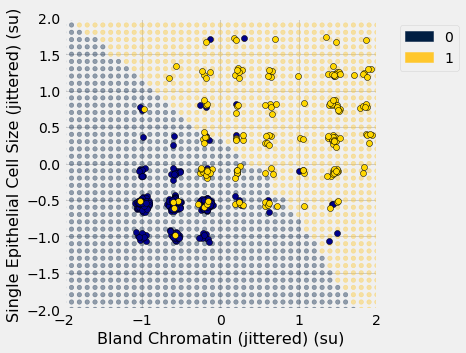

In [34]:
decision_boundary(jittered, 101)

<img src = '131.jpg' width = 400/>

If we see the areas covered in red marker, even though the majority of the points close by is yellow, the prediction turned out blue since it takes into account the data points that are far away!

Thus, we see that we need to find the balance between very small `k` and very large `k`. 

## Recap
1. The `k`-NN classifier takes a vote of the `k` closest points

2. How do we choose `k`?
    * Look at the accuracy of the classifier on the `test set`
    
3. The decision boundary
    * Shows where the classifier changes its prediction
    * The changes depend on the value of `k`